In [9]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F


%matplotlib inline

In [10]:
# read all words
words = open("./makemore/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [11]:
len(words)

32033

In [12]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [13]:
import random
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

# build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w +".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [14]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [97]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5 / 3) / (n_embd * block_size) ** 0.5 # * 0.2   # multiply with a factor to make the pre-activation of h closer to 0
b1 = torch.randn(n_hidden,                          generator=g) * 0.01  # multiply with a factor to make the pre-activation of h closer to 0 
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01  # multiply with a factor to make loss upon initialization closer to 0
b2 = torch.randn(vocab_size,                        generator=g) * 0     # multiply with a factor to make loss upon initialization closer to 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of trainable parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [79]:
(5 / 3) / (n_embd * block_size) ** 0.5 # factor for W1 which makes C @ W1 a standard normal gaussian

0.3042903097250923

tensor(-0.0006) tensor(0.9960)
tensor(-7.8157e-05) tensor(1.0277)


(array([6.30244318e-05, 4.20162878e-05, 0.00000000e+00, 1.68065151e-04,
        2.52097727e-04, 3.78146591e-04, 4.41171022e-04, 8.19317613e-04,
        1.47057007e-03, 2.58400170e-03, 4.15961250e-03, 7.05873636e-03,
        1.08191941e-02, 1.86972481e-02, 2.73946197e-02, 4.18482227e-02,
        6.53353276e-02, 9.61962910e-02, 1.36111764e-01, 1.87350627e-01,
        2.44786893e-01, 3.11718839e-01, 3.67369413e-01, 4.03503420e-01,
        4.19637675e-01, 4.04700884e-01, 3.60184627e-01, 2.96277854e-01,
        2.31887893e-01, 1.78779305e-01, 1.27666491e-01, 8.82972289e-02,
        5.91379251e-02, 3.88650662e-02, 2.52097727e-02, 1.55040102e-02,
        9.99987650e-03, 6.26042689e-03, 4.34868579e-03, 2.60500985e-03,
        1.44956193e-03, 1.00839091e-03, 5.25203598e-04, 2.52097727e-04,
        2.10081439e-04, 1.26048864e-04, 4.20162878e-05, 4.20162878e-05,
        2.10081439e-05, 2.10081439e-05]),
 array([-5.80797958, -5.56997664, -5.33197371, -5.09397077, -4.85596783,
        -4.61796489, 

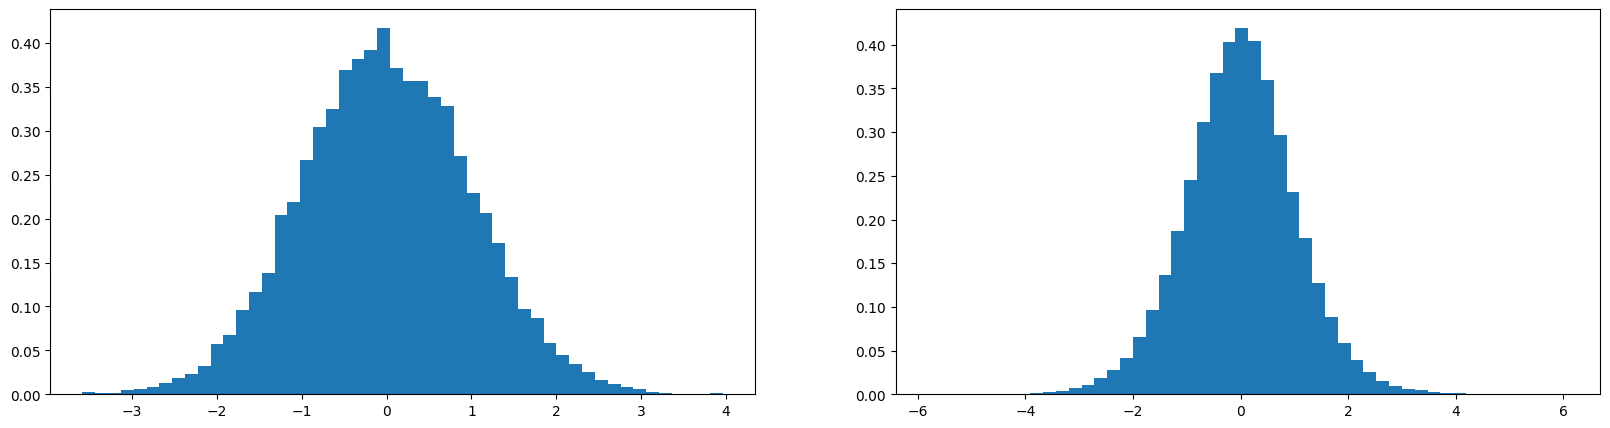

In [72]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # the denominator is due to the fact that we want to preservethe gaussian after the matmul x @ w. (Kaiming init!!!)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [98]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation # NOTE: if you normalize a layer, adding a bias previously gets thrown out anyways!
    # BatchNorm layer
    # --------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # normalize the batch to be a unit gaussian and then scale it
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # --------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if not i % 10000: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


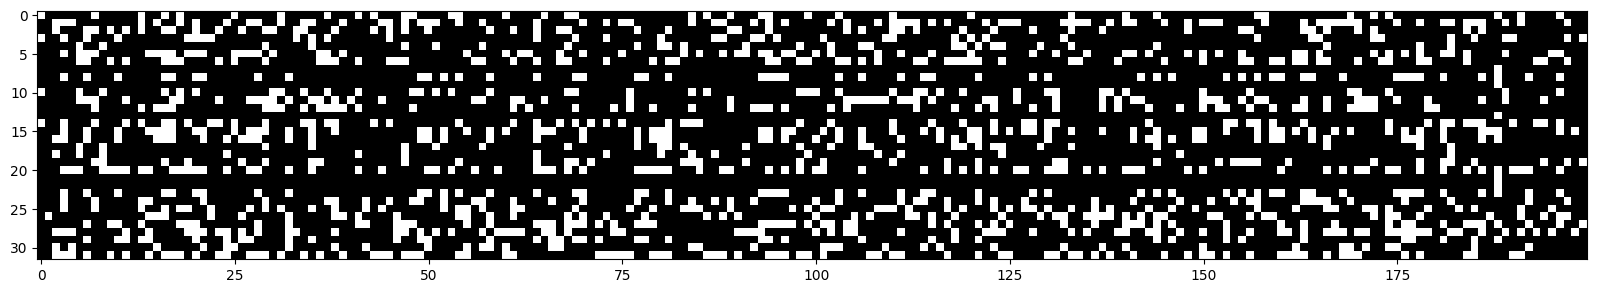

In [82]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

(array([1059.,  229.,  163.,  142.,   95.,   83.,   67.,   63.,   57.,
          65.,   76.,   51.,   69.,   65.,   85.,   91.,   75.,   53.,
          62.,   76.,   70.,  100.,  117.,   91.,  110.,  125.,  104.,
          72.,  108.,   70.,   62.,   62.,   65.,   64.,   54.,   58.,
          65.,   62.,   53.,   53.,   53.,   66.,   67.,   81.,   93.,
         101.,  116.,  179.,  231., 1122.]),
 array([-9.99999940e-01, -9.59999942e-01, -9.19999943e-01, -8.79999944e-01,
        -8.39999945e-01, -7.99999946e-01, -7.59999948e-01, -7.19999949e-01,
        -6.79999950e-01, -6.39999951e-01, -5.99999952e-01, -5.59999954e-01,
        -5.19999955e-01, -4.79999956e-01, -4.39999957e-01, -3.99999958e-01,
        -3.59999959e-01, -3.19999961e-01, -2.79999962e-01, -2.39999963e-01,
        -1.99999964e-01, -1.59999965e-01, -1.19999967e-01, -7.99999678e-02,
        -3.99999690e-02,  2.98023224e-08,  4.00000286e-02,  8.00000274e-02,
         1.20000026e-01,  1.60000025e-01,  2.00000024e-01,  2.400000

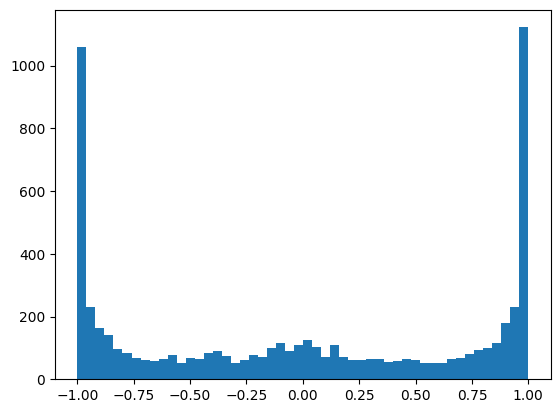

In [83]:
plt.hist(h.view(-1).tolist(), 50)

(array([  4.,   3.,   0.,   6.,   4.,   8.,   9.,  14.,  32.,  30.,  39.,
         69.,  68.,  73., 124., 156., 164., 192., 232., 291., 318., 369.,
        630., 891., 491., 340., 310., 299., 224., 221., 173., 124., 112.,
         92.,  67.,  43.,  49.,  31.,  34.,  21.,  17.,   8.,   3.,   4.,
          5.,   1.,   1.,   1.,   2.,   1.]),
 array([-8.9167347 , -8.5355937 , -8.15445271, -7.77331171, -7.39217072,
        -7.01102972, -6.62988873, -6.24874773, -5.86760674, -5.48646574,
        -5.10532475, -4.72418375, -4.34304276, -3.96190176, -3.58076077,
        -3.19961977, -2.81847878, -2.43733778, -2.05619678, -1.67505579,
        -1.29391479, -0.9127738 , -0.5316328 , -0.15049181,  0.23064919,
         0.61179018,  0.99293118,  1.37407217,  1.75521317,  2.13635416,
         2.51749516,  2.89863615,  3.27977715,  3.66091814,  4.04205914,
         4.42320013,  4.80434113,  5.18548212,  5.56662312,  5.94776411,
         6.32890511,  6.7100461 ,  7.0911871 ,  7.47232809,  7.85346909,
 

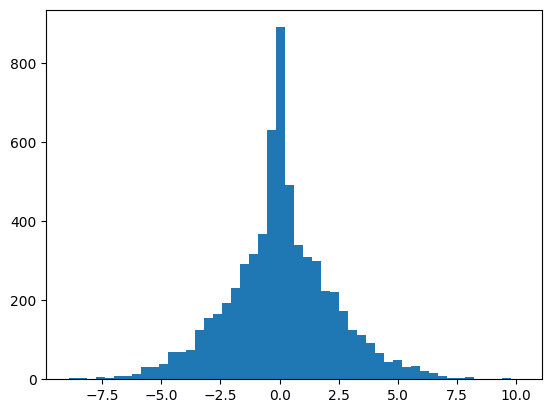

In [84]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [26]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

We realise that the initialisation of the neural network is bad! We expect that each character (letter) has the same probability. Therefore, each probability would be 1/27. We then expect the initial loss to be the negative log of this probability (see the next cell). To solve this, one usually sets the bias for the output layer to 0 and the weights (`W2` in our case) very small (by multiplying a small factor).

In [23]:
expected_loss = - torch.tensor(1 / 27.0).log()

print(expected_loss)

tensor(3.2958)


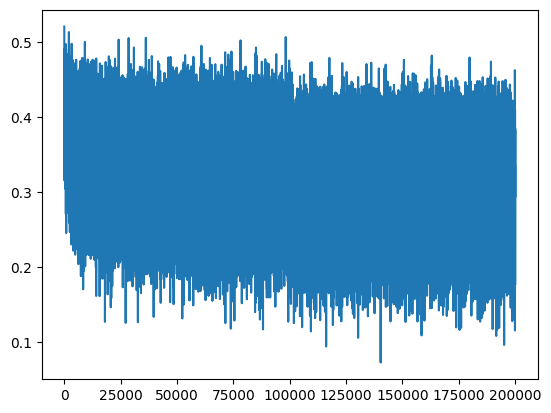

In [65]:
plt.plot(lossi)

In [99]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over entire training set
    bnmean = hpreact.mean(0, keepdim=True) 
    bnstd = hpreact.std(0, keepdim=True) 

# NOTE: this explicit calibration is not needed, since we determine the bnmean and bnstd alongside the training!

In [104]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # NOTE: if you normalize a layer, adding a bias previously gets thrown out anyways!
    # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # normalize with mean/std determined over entire training set
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # normalize with mean/std learned alongside training
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")


train 2.066591501235962
val 2.1050572395324707


In [67]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize as "..."
    while True:
        
        # forward pass the neural network
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 +b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special "." token, break

        if not ix:
            break
    
    print("".join(itos[i] for i in out)) # decode and print the generated word

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.
